# Topology Optimization of a Membrane and Report Generation with $\LaTeX$

In [1]:
import sympy as sy
from sympy import symbols, Function, diff, Matrix, MatMul, \
    integrate, Symbol, sin, cos, pi, simplify
import pylatex as pltx
from pylatex import Command, NoEscape, Tabular
from latexdocs.utils import expr_to_ltx, expr_to_ltx_breqn
from neumann.linalg import inv_sym_3x3

In [2]:
from latexdocs import Document
from latexdocs.utils import floatformatter

f2s = floatformatter(sig=4)

title = "Topology Optimization with the Optimality Criteria Method"
doc = Document(title=title, author='Bence Balogh', date=True)

In [3]:
Lx = 15.
Ly = 10.
nx = 45
ny = 30
E = 12000.
nu = .2
t = .25
Fz = -100.0

## Define a Mesh

In [4]:
from polymesh.grid import gridQ9
import numpy as np

size = Lx, Ly
shape = nx, ny

gridparams = {
    'size': size,
    'shape': shape,
    'origo': (0, 0),
    'start': 0
}

coords_, topo = gridQ9(**gridparams)
coords = np.zeros((coords_.shape[0], 3))
coords[:, :2] = coords_[:, :]


## Define a Material

In [5]:
A = np.array([[1, nu, 0], [nu, 1, 0], [0., 0, (1-nu)/2]]) * (t * E / (1-nu**2))

In [6]:
table = Tabular('c|c')
table.add_row(('Shape', (Lx, Ly)))
table.add_row(('Size', (nx, ny)))
table.add_row(('Thickness', t))
table.add_row(("Young's modulus", E))
table.add_row(("Poisson's ratio", nu))
doc['Input'].append(table)

## Set Boundary Conditions

In [7]:
from polymesh.utils.space import index_of_closest_point

# fix points at x==0
#cond = (coordsQ4[:, 0] <= 0.001) & (coordsQ4[:, 1] >= (Ly/2))
cond = coords[:, 0] <= 0.001
ebcinds = np.where(cond)[0]
fixity = np.zeros((coords.shape[0], 6), dtype=bool)
fixity[ebcinds, :] = True
#fixity[:, 2:] = True

# unit vertical load on points at (Lx, Ly)
loads = np.zeros((coords.shape[0], 6))
loadindex = index_of_closest_point(coords, np.array([2.5*Lx/3, Ly/2, 0]))
loads[loadindex, 1] = Fz


## Assembly and Solution

In [8]:
from polymesh.space import StandardFrame
from sigmaepsilon.solid.fem.mesh import FemMesh
from sigmaepsilon.solid.fem.structure import Structure
from sigmaepsilon.solid.fem.cells import Q9_M as Q9
from sigmaepsilon.solid import PointData

GlobalFrame = StandardFrame(dim=3)
pd = PointData(coords=coords, frame=GlobalFrame, loads=loads, fixity=fixity)
cd = Q9(topo=topo, material=A, frame=GlobalFrame)
meshQ4 = FemMesh(pd, cd, frame=GlobalFrame)
structure = Structure(mesh=meshQ4)

structure.linear_static_analysis()
dofsol = structure.nodal_dof_solution()
structure.mesh.pointdata['x'] = coords + dofsol[:, :3]


## Triangulate and Plot

In [9]:
%matplotlib inline


In [10]:
from polymesh.utils.topology.tr import Q4_to_T3
from polymesh.trimesh import triangulate
from dewloosh.mpl import triplot
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
plt.style.use("classic") 

points, triangles = Q4_to_T3(structure.mesh.coords(), topo)
triobj = triangulate(points=points[:, :2], triangles=triangles)[-1]


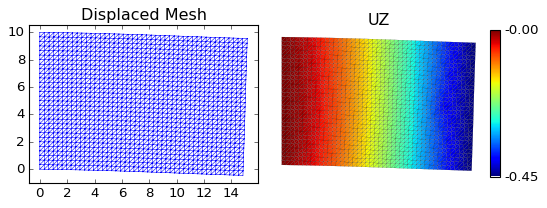

In [11]:
fig = plt.figure(figsize=(7, 4))  # in inches
fig.patch.set_facecolor('white')
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
triplot(triobj, ax=ax1, fig=fig)
triplot(triobj, ax=ax2, fig=fig, data=dofsol[:, 1], cmap='jet', axis='off')
fig.tight_layout()
ax1.set_title('Displaced Mesh')
ax2.set_title('UZ')
#fig.suptitle('Finite Element Solution')
fig.tight_layout()
plt.savefig("simp_oc_membrane.pdf")

content = r"""
\begin{figure}[htp] \centering{
\includegraphics[scale=1.0]{simp_oc_membrane.pdf}}
\caption{Degree of freedom solution.}
\end{figure}  
"""
doc['Initial Solution'].append(NoEscape(content))

In [12]:
vol_init = structure.volume()
content = 'Volume before optimization = {}'.format(f2s.format(vol_init))
doc['Initial Solution'].append(NoEscape(content))

In [13]:
work_init = loads.flatten() @ dofsol.flatten()
work_init

40.36536609103308

## Topology Optimization

In [14]:
%matplotlib inline
plt.style.use('classic')


In [15]:
OC_params = {
    'p_start': 1.0,  # SIMP penalty factor
    'p_stop': 3.0,
    'p_inc': 0.1,
    'p_step': 5,
    'q': 0.5,  # smoothing factor
    'vfrac': 0.5,  # fraction of target volume over initial volume
    'dtol': 0.1,  # to control maximum change in the variables
    'r_min': 2 * max(Lx/nx, Ly/ny),  # for the density filter
    'miniter': 30,
    'maxiter': 100
}


In [16]:
table = Tabular('c|c')
for k, w in OC_params.items():
    table.add_row((k, f2s.format(w)))
doc['Topology Optimization', 'Parameters'].append(table)

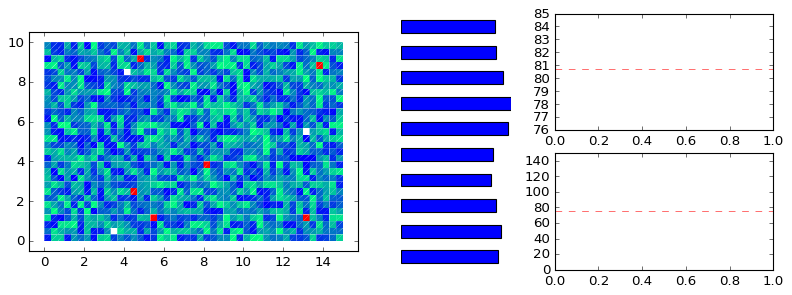

In [17]:
from neumann import histogram
from matplotlib import gridspec
import matplotlib as mpl
from IPython.display import display, clear_output

fig = plt.figure(figsize=(12, 4))  # in inches
fig.patch.set_facecolor('white')
gs = gridspec.GridSpec(2, 3, width_ratios=[6, 2, 4])

uz = structure.mesh.pointdata.dofsol[loadindex, 1].min()
nCell = structure.mesh.number_of_cells()
history = {'comp': [], 'vol': [], 'x': []}
history['comp'].append(2*uz*Fz)
history['x'].append(np.random.rand(nCell))
history['vol'].append(Lx*Ly)

nbins = 10
hist, bin_centers = histogram(history['x'][-1], nbins)
hist = hist.astype(float)
hist /= hist.max()
ax1 = fig.add_subplot(gs[:, 1])
ax1.set_facecolor('white')
bars = ax1.barh(bin_centers, hist, 0.5/nbins)
ax1.set_xlim(0, 1)
ax1.axis('off')

ax2 = fig.add_subplot(gs[0, 2])
ax2.axhline(y=history['comp'][-1], color="r", linestyle="--", lw=0.5)
#ax2.set_ylim(0, history['comp'][-1]*1.2)

ax3 = fig.add_subplot(gs[1, 2])
ax3.set_ylim(0, history['vol'][-1])
ax3.axhline(y=history['vol'][-1]*OC_params['vfrac'],
            color="r", linestyle="--", lw=0.5)

cmap = plt.cm.winter  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
#cmaplist[0] = (.5, .5, .5, 1.0)
#cmaplist[-1] = (1., 0., 0., 1.0)
# cmaplist.reverse()
cmaplist[0] = (1., 1., 1., 1.0)
cmaplist[-1] = (1., 0., 0., 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0, 10, 11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

ax4 = fig.add_subplot(gs[:, 0])
points, triangles, edata = \
    Q4_to_T3(coords, topo, data=history['x'][-1])
triobj = triangulate(points=points[:, :2], triangles=triangles)[-1]
trifield = triplot(triobj, ax=ax4, data=edata, axis='on',
                   lw=0.0, fig=fig, cmap=cmap, colorbar=False)[0]

def callback_qt(i, comp, vol, dens):
    history['comp'].append(comp)
    history['vol'].append(vol)
    history['x'].append(dens)
    fig.canvas.manager.window.raise_()
    hist, _ = histogram(dens, nbins)
    hist = hist.astype(float)
    hist /= hist.max()
    for bar, h in zip(bars, hist):
        bar.set_width(h)
    ax2.plot(i, comp, marker='o', c='b', markersize='1')
    ax3.plot(i, vol, marker='*', c='g', markersize='1')
    ax2.set_xlim(0, i+1)
    ax3.set_xlim(0, i+1)
    *_, edata = Q4_to_T3(coords, topo, data=dens)
    trifield.set_array(edata)
    fig.canvas.draw()
    fig.canvas.flush_events()


def callback_inline(i, comp, vol, dens):
    history['comp'].append(comp)
    history['vol'].append(vol)
    history['x'].append(dens)
    hist, _ = histogram(dens, nbins)
    hist = hist.astype(float)
    hist /= hist.max()

    ax1.cla()
    ax1.barh(bin_centers, hist, 0.5/nbins)
    ax2.plot(i, comp, marker='o', c='b', markersize='1')
    ax3.plot(i, vol, marker='*', c='g', markersize='1')
    ax4.cla()
    *_, edata = Q4_to_T3(coords, topo, data=dens)
    triplot(triobj, ax=ax4, data=edata, axis='on', lw=0.0,
            fig=fig, cmap=cmap, colorbar=False)[0]

    display(fig)
    clear_output(wait=True)
    plt.pause(0.1)

In [19]:
from sigmaepsilon.solid.topopt.oc import maximize_stiffness

# iteration parameters
OC_params = {
    'p_start': 1.0,  # SIMP penalty factor
    'p_stop': 2.5,
    'p_inc': 0.1,
    'p_step': 5,
    'q': 0.5,  # smoothing factor
    'vfrac': 0.4,  # fraction of target volume over initial volume
    'dtol': 0.1,  # to control maximum change in the variables
    'r_max': 3 * max(Lx/nx, Ly/ny),  # for the density filter
    'miniter': 30,
    'maxiter': 1e12,
}
OC_params['neighbours'] = structure.mesh.k_nearest_cell_neighbours(7)
optimizer = maximize_stiffness(structure,**OC_params)
next(optimizer)
ax2.set_xlim(0, len(history['comp']))
ax3.set_xlim(0, len(history['comp']))


(0.0, 1.0)

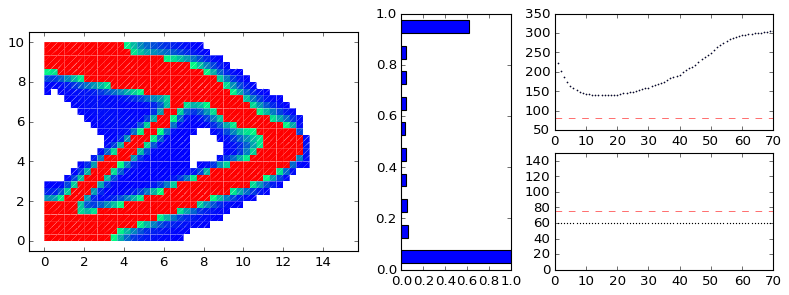

In [20]:
for i in range(70):
    r = next(optimizer)
    callback_inline(r.n, r.obj, r.vol, r.x)
    ax2.set_xlim(0, len(history['comp']))
    ax3.set_xlim(0, len(history['comp']))

In [21]:
from polymesh.utils.topology import detach

i = np.where(r.x > 0.9)[0]
coords = structure.mesh.coords()
topo = structure.mesh.topology()[i]

coords, topo = detach(coords, topo)

# fix points at x==0
cond = coords[:, 0] <= 0.001
ebcinds = np.where(cond)[0]
fixity = np.zeros((coords.shape[0], 6), dtype=bool)
fixity[ebcinds, :] = True

# unit vertical load on points at (Lx, Ly)
loads = np.zeros((coords.shape[0], 6))
loadindex = index_of_closest_point(coords, np.array([2.5*Lx/3, Ly/2, 0]))
loads[loadindex, 1] = Fz

GlobalFrame = StandardFrame(dim=3)
pd = PointData(coords=coords, frame=GlobalFrame, loads=loads, fixity=fixity)
cd = Q9(topo=topo, material=A, frame=GlobalFrame)
meshQ4 = FemMesh(pd, cd, frame=GlobalFrame)
structure_opt = Structure(mesh=meshQ4)

structure_opt.linear_static_analysis()
dofsol = structure_opt.nodal_dof_solution()
structure_opt.mesh.pointdata['x'] = coords + dofsol[:, :3]

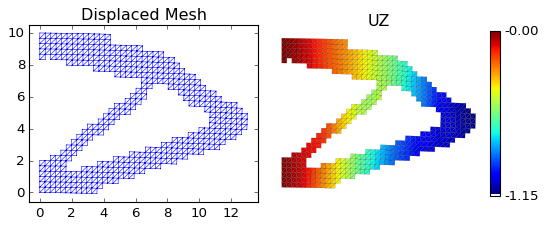

In [22]:
fig = plt.figure(figsize=(7, 4))  # in inches
fig.patch.set_facecolor('white')
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
points, triangles = Q4_to_T3(coords, topo)
triobj = triangulate(points=points[:, :2], triangles=triangles)[-1]
triplot(triobj, ax=ax1, fig=fig)
triplot(triobj, ax=ax2, fig=fig, data=dofsol[:, 1], cmap='jet', axis='off')
fig.tight_layout()
ax1.set_title('Displaced Mesh')
ax2.set_title('UZ')
#fig.suptitle('Finite Element Solution')
fig.tight_layout()
plt.savefig("membrane_oc_sol.pdf")

content = r"""
\begin{figure}[htp] \centering{
\includegraphics[scale=1.0]{membrane_oc_sol.pdf}}
\caption{The optimized structure.}
\end{figure}  
"""
doc['Topology Optimization'].append(NoEscape(content))

In [23]:
vol_opt = structure_opt.volume()
content = 'Volume after optimization = {}'.format(f2s.format(vol_opt))
doc['Topology Optimization'].append(NoEscape(content))

In [24]:
work_opt = loads.flatten() @ dofsol.flatten()
work_opt

114.38804749872382

In [25]:
table = Tabular('c|c')

v_loss = 100 * (vol_opt - vol_init) / vol_init
w_gain = 100 * (work_opt - work_init) / work_init
table.add_row(('Change in volume', f2s.format(v_loss) + '%'))
table.add_row(('Change in work', f2s.format(w_gain) + '%'))
doc['Topology Optimization', 'Summary'].append(table)

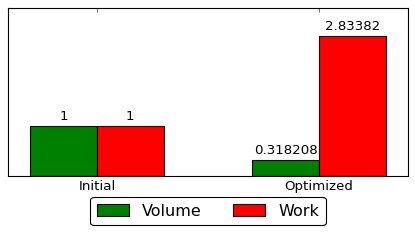

In [26]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['Initial', 'Optimized']
volumes = [1.0, vol_opt/vol_init]
works = [1.0, work_opt/work_init]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(5, 3))
fig.patch.set_facecolor('white')
rects1 = ax.bar(x - width/2, volumes, width, label='Volume', color='green')
rects2 = ax.bar(x + width/2, works, width, label='Work', color='red')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x, labels)
ax.set_yticks([])
ax.set_ylim(top=works[-1]*1.2)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=2, fancybox=True)

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

plt.subplots_adjust(left=0.0, right=1.0, bottom=0.3, top=1.0)

plt.savefig("membrane_oc_bar.pdf")

content = r"""
\begin{figure}[htp] \centering{
\includegraphics[scale=1.0]{membrane_oc_bar.pdf}}
\caption{Change of quantities related to the performance of a configuration.}
\end{figure}  
"""
doc['Topology Optimization', 'Summary'].append(NoEscape(content))

In [27]:
doc.build().generate_pdf('membrane_oc_console_Q9', clean_tex=True)

In [ ]:
doc.build().generate_tex('membrane_oc_console_Q9')